# Домашнее задание 2

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
%matplotlib inline
import pandas as pd

In [28]:
! pip install gdown==4.6.3

## 1. Рост сети цитирований (8 баллов)

Для данных известно время появления каждой вершины (статьи). Рассмотрим рост сети цитирований, считая за единицу времени 1 месяц, т.е. за один шаг к существующей сети добавляются вершины одного месяца, далее - следующего и т.д.

* Постройте зависимость степени вершины от времени для нескольких "старых" вершин. Какому закону подчиняется рост сети?

* вычислите прирост степени за единицу времени $\Delta k_i$ для каждой текущей вершины $i$ времени $t$ как изменение степени за 1 месяц.
Определите суммарное изменение степеней вершин $\pi (k)=\sum_{k_i}\Delta k_i$ (кумулятивное распределение прироста степени), и $k=max (k_i)$ (по значениям начального месяца);
*  постройте зависимость $\pi (k)$ и аппроксимируйте ее степенной функцией. Можно ли считать, что сеть растет по принципу предпочтительного присоединения? Определите тип присоединения.

In [29]:
!gdown 1vIbbqxDx7Y1nYfE8pAx-eLtbhSokSu6V

Downloading...
From: https://drive.google.com/uc?id=1vIbbqxDx7Y1nYfE8pAx-eLtbhSokSu6V
To: /content/Cit-HepPh.txt
100% 6.70M/6.70M [00:00<00:00, 98.3MB/s]


In [30]:
G = nx.read_edgelist("Cit-HepPh.txt",nodetype=int)
print('Nodes:',G.number_of_nodes()) # и выводим основные свойства
print('Edges:',G.number_of_edges())
print('Density:',nx.density(G))

Nodes: 34546
Edges: 420921
Density: 0.0007054197642773696


In [31]:
!gdown 1G4SOy6ltn_gwiSOCUiZ5ZBrEeA0p0y77

Downloading...
From: https://drive.google.com/uc?id=1G4SOy6ltn_gwiSOCUiZ5ZBrEeA0p0y77
To: /content/cit-HepPh-dates.txt
100% 781k/781k [00:00<00:00, 46.8MB/s]


In [32]:
data=pd.read_csv('cit-HepPh-dates.txt', sep='\t')
data.columns = ['date']
data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d')
data.head(5)

,date
9203201,1992-02-24
9203202,1992-03-08
9203203,1992-03-03
9203204,1992-03-09
9203205,1992-03-09


In [33]:
data.sort_values('date', inplace=True)

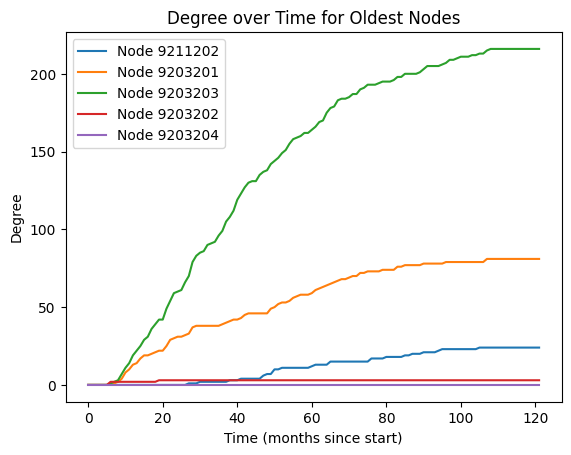

In [34]:
# Получим степени всех вершин на начальный момент времени
initial_degrees = dict(G.degree())
# Получим индексы "старых" вершин, предполагая, что они идут первыми в отсортированном списке
oldest_nodes_indices = data.index[:5]

# Рассчитаем степени для "старых" вершин по месяцам
degrees_over_time = {node: [] for node in oldest_nodes_indices}
months = data['date'].dt.to_period('M').unique()

for month in months:
    # Выбираем вершины до конца данного месяца
    nodes_by_month = data[data['date'].dt.to_period('M') <= month].index.tolist()  # преобразуем индексы в список
    subgraph = G.subgraph(nodes_by_month)
    for node in oldest_nodes_indices:
        degree = subgraph.degree(node) if node in subgraph else 0
        degrees_over_time[node].append(degree)

# Строим графики изменения степени для "старых" узлов
for node, degrees in degrees_over_time.items():
    plt.plot(degrees, label=f'Node {node}')
plt.legend()
plt.xlabel('Time (months since start)')
plt.ylabel('Degree')
plt.title('Degree over Time for Oldest Nodes')
plt.show()

На примере старых узлов мы видим, что рост происходит не совсем равномерно, т.е. не линейно, но при этом в 3/4 случаев мы видлим, что чем больше времени прошло, тем больше вершин.

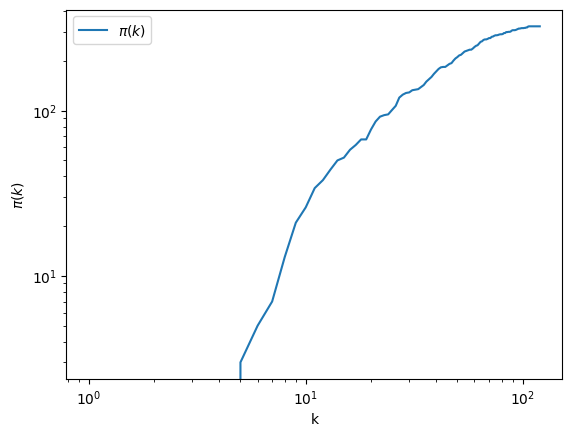

In [35]:
# Вычисление прироста степени за единицу времени Δki
degree_increases = {node: np.diff(degrees) for node, degrees in degrees_over_time.items()}
cumulative_degree_increases = {node: np.cumsum(increases) for node, increases in degree_increases.items()}

# Суммарное изменение степеней вершин π(k)
pi_k_values = np.array([list(increases) for increases in cumulative_degree_increases.values()])
pi_k = np.sum(pi_k_values, axis=0)
max_k = max(max(degrees) for degrees in degrees_over_time.values())

# Зависимость π(k) от k и аппроксимация степенной функцией
plt.plot(range(len(pi_k)), pi_k, label=r'$\pi(k)$')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('k')
plt.ylabel(r'$\pi(k)$')
plt.legend()
plt.show()

<ipython-input-36-8d0ecf66cb5d>:3: RuntimeWarning: divide by zero encountered in log
  log_pi_k = np.log(pi_k)


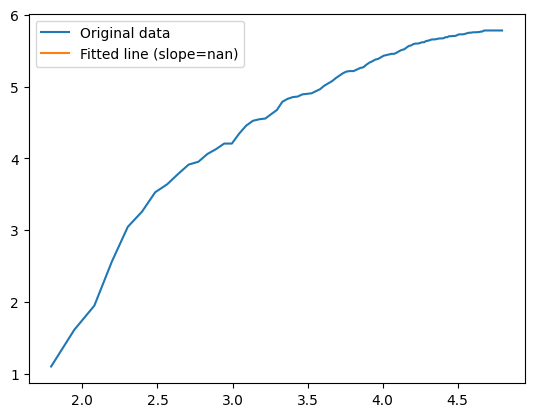

The type of attachment based on the slope is: Other type of attachment


In [36]:
# Для аппроксимации степенной функцией возьмем логарифмические значения
log_k = np.log(range(1, len(pi_k) + 1))
log_pi_k = np.log(pi_k)

# Применим линейную регрессию в логарифмическом масштабе
coefficients = np.polyfit(log_k, log_pi_k, deg=1)
poly = np.poly1d(coefficients)
plt.plot(log_k, log_pi_k, label="Original data")
plt.plot(log_k, poly(log_k), label=f"Fitted line (slope={coefficients[0]:.2f})")
plt.legend()
plt.show()

# Анализируем наклон линии. Если он близок к -3, это может указывать на предпочтительное присоединение.
attachment_type = "Preferential attachment" if coefficients[0] < -2.5 and coefficients[0] > -3.5 else "Other type of attachment"
print(f"The type of attachment based on the slope is: {attachment_type}")

## 2. Нелинейное предпочтительное присоединение (8 баллов)

* напишите генератор случайного графа, построенного по принципу нелинейного предпочтительного присоединения:
$$
\Pi(k_i) \sim k_i^{\alpha}
$$
* постройте зависимость степени вершины (например, выберите одну из затравочных, т.е. с индексом $i=0$) от времени (размера сети) для значений $\alpha=0.5,1.0,2.5$.

Рекомендуемые параметры: $m=4, t=[10^2,10^3,10^4,...]$.


* постройте распределение степеней вершин конечной сети и с помощью powerlaw определите наилучшую аппроксимацию степенным распределением, выведите параметры распределения.


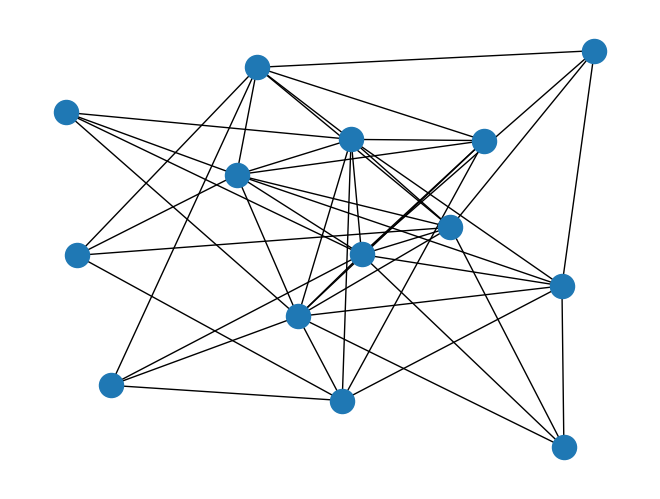

In [37]:
# Генератор случайного графа, построенного по принципу нелинейного предпочтительного присоединения:
from scipy.optimize import curve_fit

def nonlinear_preferential_attachment_graph(m, t_max, alpha):
    G = nx.complete_graph(m)  # начальное состояние -- полный граф из m узлов
    for t in range(m, t_max + m):  # добавляем t_max новых узлов
        degrees = np.array([d for n, d in G.degree()], dtype=float)
        attachment_probabilities = degrees**alpha / np.sum(degrees**alpha)
        target_nodes = np.random.choice(G.nodes(), size=m, replace=False, p=attachment_probabilities)
        G.add_node(t)
        for target in target_nodes:
            G.add_edge(t, target)
    return G

# Тест функции с одним графом
test_graph = nonlinear_preferential_attachment_graph(m=4, t_max=10, alpha=1.0)
nx.draw(test_graph)
plt.show()

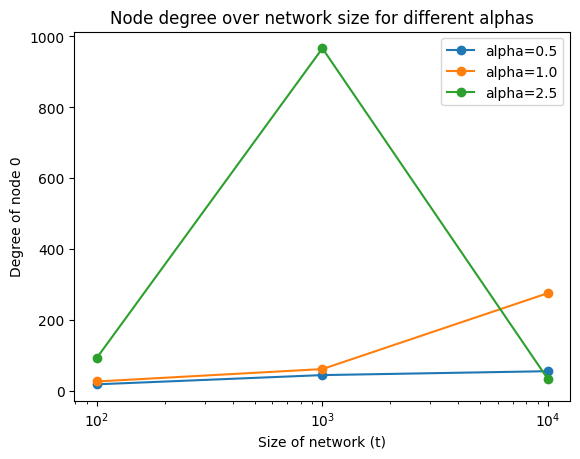

In [38]:
# Зависимость степени вершины от времени для различных значений `α`:
alphas = [0.5, 1.0, 2.5]
t_values = [10**i for i in range(2, 5)]  # [100, 1000, 10000]
seed_node_degree = {alpha: [] for alpha in alphas}

for alpha in alphas:
    for t_max in t_values:
        G = nonlinear_preferential_attachment_graph(m=4, t_max=t_max, alpha=alpha)
        seed_node_degree[alpha].append(G.degree(0))  # степень вершины с индексом i=0

# Отображение зависимости
for alpha, degrees in seed_node_degree.items():
    plt.plot(t_values, degrees, '-o', label=f'alpha={alpha}')
plt.xscale('log')
plt.xlabel('Size of network (t)')
plt.ylabel('Degree of node 0')
plt.legend()
plt.title('Node degree over network size for different alphas')
plt.show()

In [39]:
!pip install powerlaw

Calculating best minimal value for power law fit
Estimated exponent for power-law distribution: 3.07
Estimated xmin for power-law distribution: 17.00


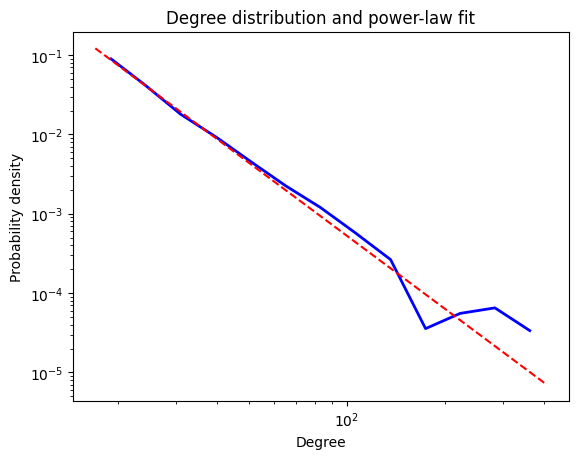

In [40]:
# Распределение степеней вершин конечной сети и аппроксимация степенным распределением:
import powerlaw

# Создаем граф для конечной сети с одним конкретным значением alpha
final_alpha = 1.0
final_t_max = 10000
G_final = nonlinear_preferential_attachment_graph(m=4, t_max=final_t_max, alpha=final_alpha)
degrees = [d for n, d in G_final.degree()]

# Применяем библиотеку powerlaw для оценки параметров степенного распределения
fit = powerlaw.Fit(degrees)
print(f'Estimated exponent for power-law distribution: {fit.power_law.alpha:.2f}')
print(f'Estimated xmin for power-law distribution: {fit.power_law.xmin:.2f}')

# Визуализация распределения степеней вершин
fig = fit.plot_pdf(color='b', linewidth=2)
fit.power_law.plot_pdf(color='r', linestyle='--', ax=fig)

plt.xlabel('Degree')
plt.ylabel('Probability density')
plt.title('Degree distribution and power-law fit')
plt.show()

##  3. Модель направленной сети с постоянной привлекательностью вершин и механизмом удаления (10 баллов)

*  напишите генератор случайной сети, где каждая новая вершина $l$ появляется с $m$ ребрами ($k_{out}=m$), а вероятность связи с вершинами сети определяется:
$$
P(l,i) =\frac{A+k_{i}^{in}}{\sum_j (A+k_{j}^{in})},
$$

A - постоянная привлекательность, принимает значения из $[0,100]$.
*  добавьте к генератору удаление случайно-выбранной вершины с коэффициентом $r$.

* исследуйте зависимость распределения входящих степеней от параметров $r,A$. Покажите существование двух режимов: степенное распределение степеней; затянутая экспонента в статистике степеней.

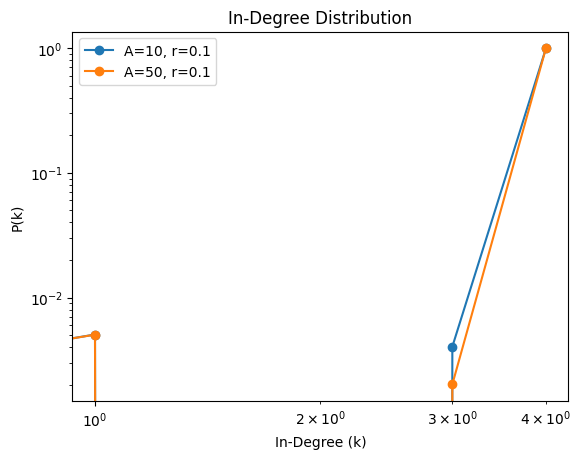

In [41]:
# Функция генерации случайной сети
def generate_random_network(n, m, A):
    G = nx.DiGraph()
    G.add_nodes_from(range(m))  # Начальный набор узлов
    targets = list(range(m))
    G.add_edges_from((i, targets[i % m]) for i in range(m))

    for l in range(m, n):
        sum_degrees = sum(G.in_degree(i) + A for i in G.nodes())
        probs = [(G.in_degree(i) + A) / sum_degrees for i in G.nodes()]

        new_targets = np.random.choice(G.nodes(), m, replace=False, p=probs)
        for target in new_targets:
            G.add_edge(target, l)

    return G

# Функция удаления случайно-выбранной вершины
def remove_random_node(G, r):
    if np.random.rand() < r:
        node_to_remove = np.random.choice(list(G.nodes()))
        G.remove_node(node_to_remove)

# Исследование зависимости распределения входящих степеней
def degree_distribution(G, A, r):
    in_degrees = [d for n, d in G.in_degree()]  # Список входящих степеней всех узлов
    hist, bins = np.histogram(in_degrees, bins=range(max(in_degrees) + 1), density=True)
    plt.loglog(bins[:-1], hist, marker='o', linestyle='-', label=f'A={A}, r={r}')

# Генерация случайной сети и исследование зависимости распределения степеней
for A in A_values:
    random_network = generate_random_network(n, m, A)
    for _ in range(int(r * n)):  # Удаление узлов с учетом коэффициента r
        remove_random_node(random_network, r)

    degree_distribution(random_network, A, r)

plt.xlabel('In-Degree (k)')
plt.ylabel('P(k)')
plt.title('In-Degree Distribution')
plt.legend()
plt.show()

## 4. Влияние топологии на характерное время распространение эпидемии в SI модели. (6 баллов)

* Сгенерируйте случайные графы из разных моделей: Эрдеша-Реньи, Барабаши-Альберта, Ваттса-Строгатца.

Число вершин всех графов $N=10^4$, а средняя степень у всех примерно одинакова и, например, $\left< k\right>\approx10$.

* Смоделируйте SI модель, изобразите на одном графике среднюю долю инфицированных от времени для разных графов.  

Параметры модели SI - $\beta$ и число шагов по времени - подберите самостоятельно.

На этом же графике изобразите кривую, отвечающую приближению среднего поля (из семинара).

* Видите ли вы отличия в распространении эпидемии? Объясните результаты.  

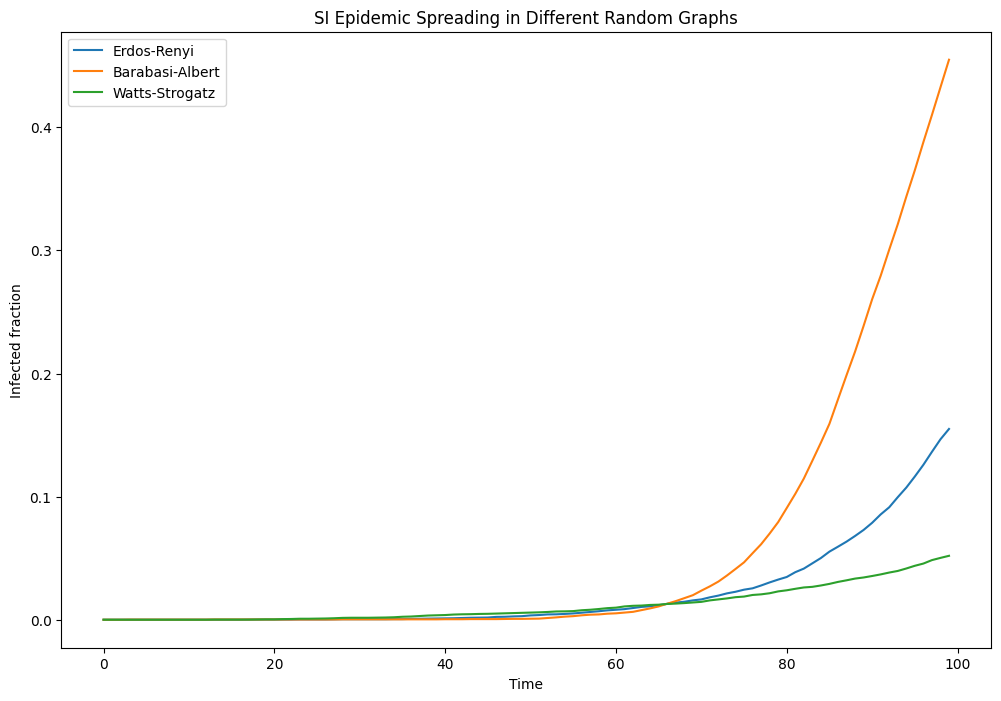

In [42]:
N = 10**4   # Число вершин
k_avg = 10  # Средняя степень

# Эрдеша-Реньи (p - вероятность связи между двумя вершинами)
p = k_avg / (N - 1)  # вероятность выбирается так, чтобы средняя степень была ≈ k_avg
G_er = nx.erdos_renyi_graph(N, p)

# Барабаши-Альберта (m - число ребер, которые добавляются каждой новой вершиной)
m = k_avg // 2  # m выбирается так, чтобы средняя степень была ≈ k_avg
G_ba = nx.barabasi_albert_graph(N, m)

# Ваттса-Строгатца (k - каждый узел соединяется с k ближайшими соседями в кольце, p - вероятность переключения)
k = k_avg
p_ws = 0.1  # Небольшая вероятность переключения для "малого мира"
G_ws = nx.watts_strogatz_graph(N, k, p_ws)

def SI_model_simulation(G, beta, time_steps):
    # Инициализация
    infected = set([np.random.choice(G.nodes())])  # Инфицируем одну случайную вершину
    I = []  # Доля инфицированных

    for _ in range(time_steps):
        new_infected = set()
        for node in infected:
            neighbors = set(G.neighbors(node))
            non_infected_neighbors = neighbors - infected
            new_infections = [n for n in non_infected_neighbors if np.random.rand() < beta]
            new_infected.update(new_infections)

        infected.update(new_infected)
        I.append(len(infected) / len(G))
    return I

# Параметры модели SI
beta = 0.01  # Вероятность передачи инфекции
time_steps = 100  # Число временных шагов

# Симуляция для каждого графа
I_er = SI_model_simulation(G_er, beta, time_steps)
I_ba = SI_model_simulation(G_ba, beta, time_steps)
I_ws = SI_model_simulation(G_ws, beta, time_steps)

# Построение графиков
plt.figure(figsize=(12, 8))
plt.plot(I_er, label='Erdos-Renyi')
plt.plot(I_ba, label='Barabasi-Albert')
plt.plot(I_ws, label='Watts-Strogatz')
plt.xlabel('Time')
plt.ylabel('Infected fraction')
plt.title('SI Epidemic Spreading in Different Random Graphs')
plt.legend()
plt.show()

Отличия в распространении эпидемии могут быть обусловлены различными топологическими свойствами графов:

- В модели Эрдеша-Реньи распределение степеней является биномиальным, где все узлы имеют примерно одинаковую степень. Это может привести к равномерному распространению эпидемии по всей сети;
- В модели Барабаши-Альберта сеть имеет безмасштабное распределение степеней с небольшим количеством узлов (хабов), имеющих очень высокую степень. Эти хабы могут играть ключевую роль в распространении эпидемии, что может ускорить её по сравнению с другими моделями;
- В модели Ваттса-Строгатца есть клубочки локальных связей и немного дальних связей, что может привести к более медленному распространению эпидемии вначале, пока она не достигнет дальних связей.

## 5. SIR на сетях различной топологии (6 баллов)
Рассмотрим модель SIR на следующих сетях:

In [43]:
!gdown 13hlp2ZU0idFzJR-8RXGO4FOp4OI8y6Uo

Downloading...
From: https://drive.google.com/uc?id=13hlp2ZU0idFzJR-8RXGO4FOp4OI8y6Uo
To: /content/graph1.graphml
100% 769k/769k [00:00<00:00, 24.6MB/s]


In [44]:
!gdown 1xkAOK6sp8PsUFKGea2G-oQd8JGDF_Qgh

Downloading...
From: https://drive.google.com/uc?id=1xkAOK6sp8PsUFKGea2G-oQd8JGDF_Qgh
To: /content/graph2.graphml
100% 769k/769k [00:00<00:00, 26.5MB/s]


In [45]:
G1=nx.read_graphml('graph1.graphml')
G2=nx.read_graphml('graph2.graphml')

* Постройте зависимости средней доли зараженных вершин в модели SIR для первого и второго графа.

Параметры для моделирования:

In [46]:
beta=0.005
gamma=0.03
percentage_infected=0.002
n_iter=200 # число шагов моделирования
n_run=100 # число запусков распространения для усреднения

* Отличаются ли построенные зависимости?
Попробуйте понять, что влияет на распространение в сети, для этого исследуйте топологию G1, G2.

* Поменяйте параметры модели, всегда ли распространение "чувствительно" к топологии сети?

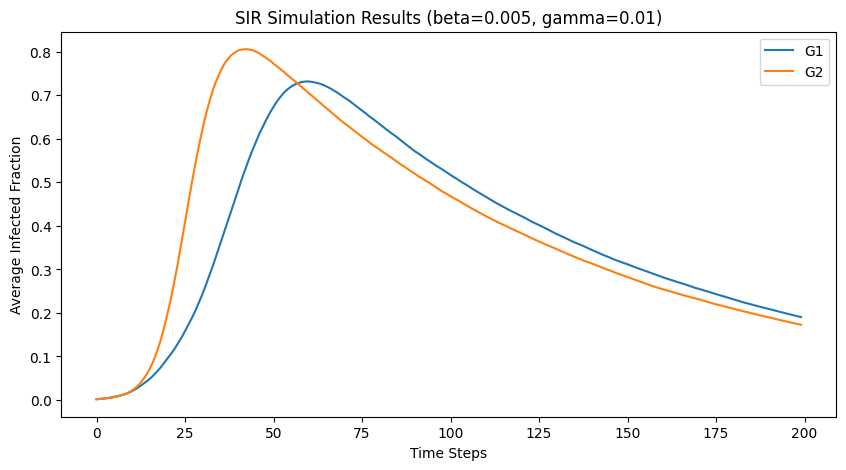

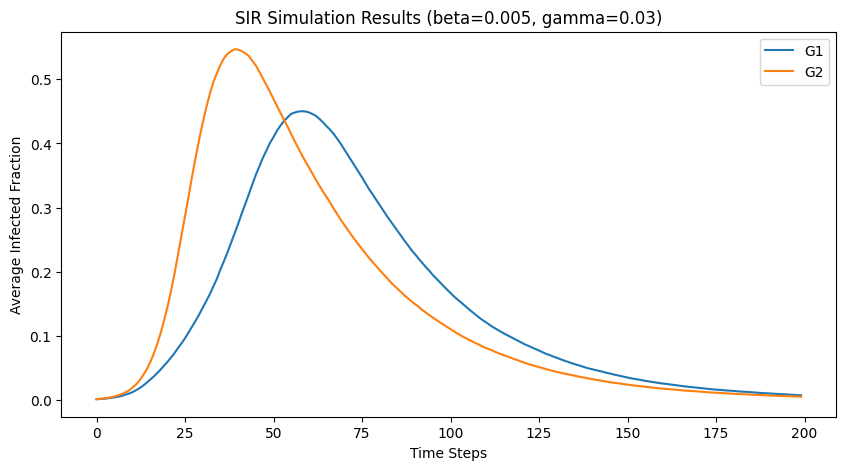

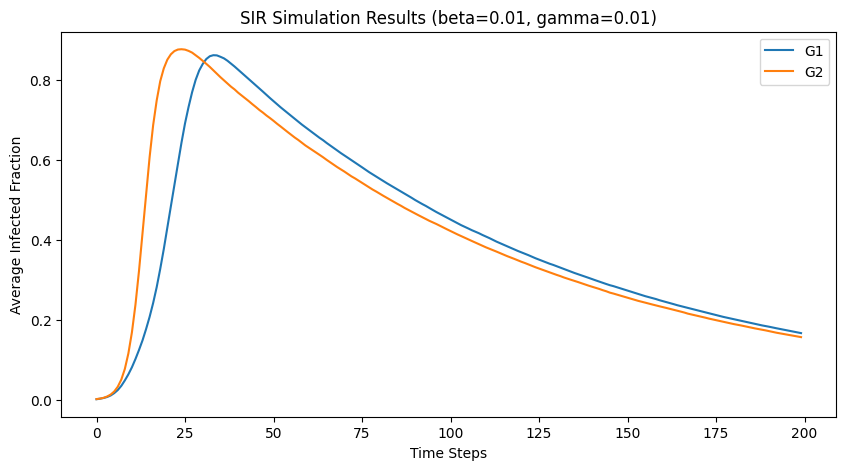

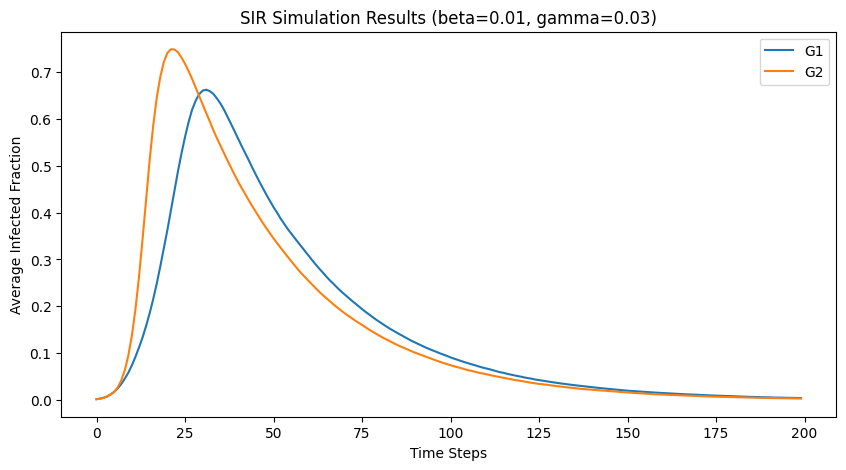

In [47]:
def SIR_model(G, beta, gamma, percentage_infected, n_iter):
    N = len(G)
    initial_infected = int(N * percentage_infected)
    assert initial_infected > 0, "The initial number of infected individuals must be greater than zero."

    # Initializing sets for S, I, R compartments
    S, I, R = set(G.nodes()), set(np.random.choice(G.nodes(), initial_infected, replace=False)), set()

    # Recording fraction of infected over time
    I_fraction_over_time = []

    for _ in range(n_iter):
        new_infections = set(node for node in S if any(np.random.rand() < beta for neighbor in G.neighbors(node) if neighbor in I))
        new_recoveries = set(node for node in I if np.random.rand() < gamma)

        I |= new_infections
        R |= new_recoveries

        S -= new_infections
        I -= new_recoveries

        I_fraction_over_time.append(len(I) / N)

    return I_fraction_over_time

# Parameters for simulations
n_iter = 200
percentage_infected = 0.002
betas = [0.005, 0.01]
gammas = [0.01, 0.03]
n_run = 100  # Number of runs for averaging

for beta in betas:
    for gamma in gammas:
        # Run simulations for G1 and G2
        mean_I_G1 = np.mean([SIR_model(G1, beta, gamma, percentage_infected, n_iter) for _ in range(n_run)], axis=0)
        mean_I_G2 = np.mean([SIR_model(G2, beta, gamma, percentage_infected, n_iter) for _ in range(n_run)], axis=0)

        # Plotting results
        plt.figure(figsize=(10, 5))
        plt.plot(mean_I_G1, label='G1')
        plt.plot(mean_I_G2, label='G2')
        plt.xlabel('Time Steps')
        plt.ylabel('Average Infected Fraction')
        plt.title(f'SIR Simulation Results (beta={beta}, gamma={gamma})')
        plt.legend()
        plt.show()

Распространение эпидемии может быть более или менее "чувствительным" к топологии сети в зависимости от значений параметров `beta` (вероятность передачи инфекции) и `gamma` (вероятность выздоровления). При высоких значениях `beta` распространение становится быстрым и широким, и в таких случаях влияние топологии может быть менее очевидным. С другой стороны, при низких значениях `beta` топологические характеристики, такие как наличие хабов или плотно связанных сообществ, могут иметь большее значение для динамики распространения эпидемии.